In [1]:
import numpy as np
import warnings
warnings.filterwarnings('ignore') #ignore warnings

## Load mnist data using sci-kit learn

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
data, label = mnist['data'], mnist['target']
print(type(data))

<class 'pandas.core.frame.DataFrame'>


In [4]:
print(type(data))
label[:10]

<class 'pandas.core.frame.DataFrame'>


0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

Note that labels a in form of string not a numeric values

Let's look at the size of data and target

In [5]:
print(data.shape)
print(label.shape)

(70000, 784)
(70000,)


The dataset consist of 70000 images and each image has 784 features, of hand written digit with size of 28x28 -- features are flatten

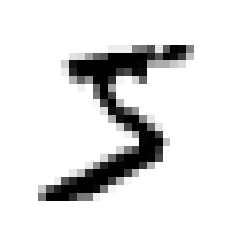

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt

sample_digit = data.iloc[0].to_numpy() # data series not allow reshape
sample_digit_image = sample_digit.reshape(28, 28)
plt.imshow(sample_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()


Labels are in type of string so convert it into integers

In [7]:
label = label.astype(np.uint8)
label[:10]

0    5
1    0
2    4
3    1
4    9
5    2
6    1
7    3
8    1
9    4
Name: class, dtype: uint8

Let split the data set into train and test sets

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
        data, 
        label, 
        test_size=0.14, 
        shuffle=True)

# Binary classification

Try to identify one digit (1 vs all) - convert problem into binary classification

In [9]:
# filter pandas label series by masking and convert it for binary classification

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

y_train_5.value_counts()

False    54802
True      5397
Name: class, dtype: int64

Out of 60199 images, 5408 hand written images are labelled as 5 - (less than 9%)

## let try with SGDClassifier

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_classifier = SGDClassifier()
sgd_classifier.fit(X_train, y_train_5)

SGDClassifier()

In [11]:
sgd_classifier.predict([data.loc[0]])

array([ True])

## Measure accuracy using cross validation

In [12]:
from sklearn.model_selection import cross_val_score #kfold cross validation
cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95554891, 0.94936709, 0.96376956])

Overall accuracy is good but try to classify non-5 class

In [13]:
from sklearn.base import BaseEstimator

class Non_5_classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [14]:
non_5_classifier = Non_5_classifier()
cross_val_score(non_5_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90815767, 0.90885079, 0.91403369])

This different is due to only 10% of training set are number 5

## Measure accuracy using Confusion matrix

In [15]:
# to use confusion matrix we need actual prediction
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

### Confusion matrix

confusion matrix help us to measure performance of skewed class

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53447,  1355],
       [ 1674,  3723]])

false postives - 592 (non 5's are classified as 5)

false negative - 1661 (5's are classified as non-5) 

to improve our model we try to reduce these values

Row represent the actual class and column represent the predicted class

## Precision and Recall - best for skwed classes

In [17]:
# precision and recall 
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.7331626624655376
0.6898276820455809


In [18]:
# f1 score - single number evaluation metric (combination of precision and recall)
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.710835322195704

## Trade-off between precision and recall

Changing threshold based on precision and recall is way to imporve model perfomance

We can use precision_recall_curve or pricision vs recall to pick a value for threshold

let's visualize precision vs recall and determine threshold value

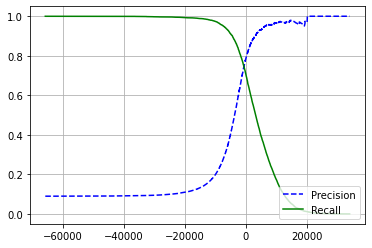

In [19]:
from sklearn.metrics import precision_recall_curve

# using decision_function method we can get an array of score
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3,
    method="decision_function") 

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.legend(loc='lower right')
plt.grid('true')
plt.show()

So, we need to find the lowest threshold which give highest precision and recall scores

Other way is Precision vs Recall

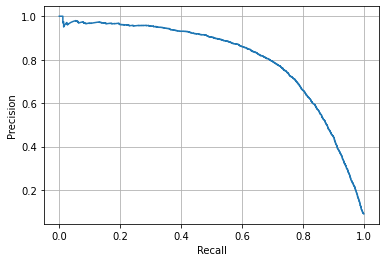

In [20]:
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid('true')
plt.show()

Precision really starts to fall sharply around 80% recall. We will probably want to select a precision/recall tradeoff just before that drop.

In [21]:
# the lowest threshold which give 90% precision
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3004.333147167208

In [22]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000327761389708
0.5088011858439874


## Comparing models using ROC curve and AUC score

Instead of predict actual values predict decision scores for each instance using cross_val_predict

In [23]:
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3, method='decision_function')

ROC curve is best for binary classification, it plots the true positive rate 
(another name for recall) against the false positive rate

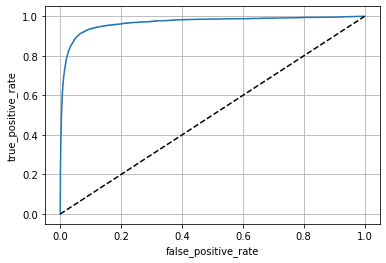

In [24]:
from sklearn.metrics import roc_curve
false_postive_rate, true_positive_rate, thresholds = roc_curve(y_train_5, y_scores)
plt.plot(false_postive_rate, true_positive_rate)
plt.plot([0,1], [0,1], 'k--') # diagonal
plt.xlabel('false_positive_rate')
plt.ylabel('true_positive_rate')
plt.grid(True)
plt.show()

The good classifier stays as far from the diagonal line (toward the top-left corner)

We can use area under the curve (AUC) to calculate accurate value rather than visual

In [25]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9681502862018866

## Let train with RandomForestClassifier

In [26]:
from sklearn.ensemble import RandomForestClassifier
forest_classifier = RandomForestClassifier()

# we can't call decision_funtion for forest classifier but instead we can use predic_prob
y_prob = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3, 
    method='predict_proba')
# since the predict_proba method return row for each instance and column for each class    
y_prob = y_prob[:, 1]
print(y_prob[:5])

[0.   0.05 0.   0.   0.02]


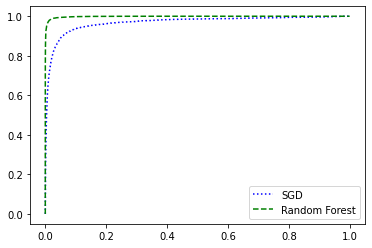

In [27]:
# comparing roc curves
false_postive_rate_forest, true_positive_rate_forest, thresholds_forest = roc_curve(y_train_5, y_prob)
plt.plot(false_postive_rate, true_positive_rate, 'b:', label='SGD')
plt.plot(false_postive_rate_forest, true_positive_rate_forest, 'g--', label='Random Forest')
plt.legend(loc='lower right')
plt.show()

let compute the AUC

In [28]:
roc_auc_score(y_train_5, y_prob)

0.9985843371373693

Try to measure precision and recall score

In [29]:
y_train_pred_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3)
print(precision_score(y_train_5, y_train_pred_forest))
print(recall_score(y_train_5, y_train_pred_forest))

0.9902169289663972
0.8627015008337966


# Multiclass classification

In [30]:
# let try with SGDClassifier
# SGD classifier work for multi-class classification as well
sgd_multi_class_classifier = SGDClassifier()
sgd_multi_class_classifier.fit(X_train, y_train)

SGDClassifier()

In [34]:
sgd_multi_class_classifier.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [31]:
# predict sample image
sgd_multi_class_classifier.predict([sample_digit])

array([5], dtype=uint8)

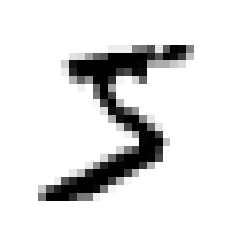

In [35]:
plt.imshow(sample_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [33]:
# cross validation scores using test-set
y_multi_class_pred_scores = cross_val_score(sgd_multi_class_classifier, X_test, y_test, cv=3, scoring='accuracy')
y_multi_class_pred_scores

array([0.85950413, 0.86929905, 0.86929905])

In [54]:
# lets try with scaled data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_tranformed = scaler.fit_transform(X_train.astype(np.float64))

In [55]:
# train new classifier with transormed/scalled inputs
sgd_multi_class_classifier2 = SGDClassifier()
sgd_multi_class_classifier2.fit(X_train_tranformed, y_train)

SGDClassifier()

In [56]:
# cross validation scores using test-set
y_multi_class_pred_scores = cross_val_score(sgd_multi_class_classifier2, X_test, y_test, cv=3, scoring='accuracy')
y_multi_class_pred_scores

array([0.86715641, 0.85919804, 0.85338231])

We have slight improvement due to scalling ****

## We can use sklearn One-vs-One or One-vs-All classifier

In [37]:
from sklearn.multiclass import OneVsOneClassifier
ovo_classifier = OneVsOneClassifier(SGDClassifier()) # pass binary classifier as contructor
ovo_classifier.fit(X_train, y_train)

OneVsOneClassifier(estimator=SGDClassifier())

In [42]:
# do prediction
ovo_classifier.predict([sample_digit])

array([3], dtype=uint8)

miss prediction

In [40]:
# cross validation
y_ovo_pred_scores = cross_val_score(ovo_classifier, X_test, y_test, 
                    cv=3, scoring='accuracy')
y_ovo_pred_scores

array([0.91368228, 0.91796755, 0.90633609])

## Lets try with RandomForest Classifier

In [41]:
random_forest_multi_class_classifier = RandomForestClassifier()
random_forest_multi_class_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [43]:
# do predicition
random_forest_multi_class_classifier.predict([sample_digit])

array([5], dtype=uint8)

In [44]:
# cross validation 
y_pred_random_forest_scores = cross_val_score(random_forest_multi_class_classifier,
                            X_test, y_test, cv=3, scoring='accuracy')
y_pred_random_forest_scores

array([0.94276094, 0.95347414, 0.94367922])

Keep in mind random forest can directly classify instance into multiple classes, rather than one vs one or one vs all

In [49]:
# let have a look on each class probability of predicition
prob_scores = random_forest_multi_class_classifier.predict_proba([sample_digit])
prob_scores

array([[0.03, 0.02, 0.03, 0.18, 0.  , 0.65, 0.  , 0.02, 0.02, 0.05]])

In [48]:
np.argmax(prob_scores)

5

Lets evaluate with f1 score

In [53]:
y_pred_random_forest_multi_class = cross_val_predict(random_forest_multi_class_classifier,
                    X_test, y_test, cv=3)
f1_score(y_test, y_pred_random_forest_multi_class, average=None)

array([0.96487603, 0.97410268, 0.94094869, 0.92040063, 0.95238095,
       0.93522047, 0.96405063, 0.94950495, 0.92129884, 0.92315789])

Summary: 
1. Coverted the problem as binary classification
2. Used different algorithm for binary classification and evaluated scores
3. Multi class classification - original problem
4. Used different algorithm for multi-class classification and evaluated scores  

** RandomForest classifier work well on both
** With feature scalling we can improve model performance
** For skewed class - wheare positve example are much less use precision, recall and f1 score matrices for evaluation (based on senario) 